In [1]:
import pandas as pd
import numpy as np
import wordcloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
#otvaranje dat
df = pd.read_csv("spamham.csv",encoding='utf-8')
df.head()

,kategorija,poruka
0,spam,"Neseseri odabrala je vas! Dragi korisnice, ima..."
1,spam,Pogodite tko se vratio? 50% popusta na artikle...
2,spam,"Toplinski val ne posustaje, a nogometna grozni..."
3,spam,"Dragi korisniče, vaša pošiljka iz pošte ne mož..."
4,spam,OBAVIJEST O PRIMJENI ČLANKA 54b. (Izuzeće od o...


In [3]:
#osnovni podaci
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   kategorija  17 non-null     object
 1   poruka      17 non-null     object
dtypes: object(2)
memory usage: 400.0+ bytes


In [4]:
print("Broj poruka po kategoriji \n",df['kategorija'].value_counts())


Broj poruka po kategoriji 
 ham     9
spam    8
Name: kategorija, dtype: int64


In [5]:
print("Postotak pravih poruka:",round(len(df[df['kategorija']=="spam"])/len(df['kategorija']),2)*100,"%")
print("Postotak spam poruka:",round(len(df[df['kategorija']=="ham"])/len(df['kategorija']),2)*100,"%")

Postotak pravih poruka: 47.0 %
Postotak spam poruka: 53.0 %


In [6]:
#stvaranje nove kolumne duljina
df['duljina'] = df.poruka.str.len()
df.head()

,kategorija,poruka,duljina
0,spam,"Neseseri odabrala je vas! Dragi korisnice, ima...",151
1,spam,Pogodite tko se vratio? 50% popusta na artikle...,78
2,spam,"Toplinski val ne posustaje, a nogometna grozni...",300
3,spam,"Dragi korisniče, vaša pošiljka iz pošte ne mož...",149
4,spam,OBAVIJEST O PRIMJENI ČLANKA 54b. (Izuzeće od o...,153


In [7]:
#pretvaranje svih poruka u mala slova
df['poruka'] = df['poruka'].str.lower()
df.head()

,kategorija,poruka,duljina
0,spam,"neseseri odabrala je vas! dragi korisnice, ima...",151
1,spam,pogodite tko se vratio? 50% popusta na artikle...,78
2,spam,"toplinski val ne posustaje, a nogometna grozni...",300
3,spam,"dragi korisniče, vaša pošiljka iz pošte ne mož...",149
4,spam,obavijest o primjeni članka 54b. (izuzeće od o...,153


In [8]:
#uklanjanje posebnih znakova
df['poruka'] = df['poruka'].str.replace(r'[^\w\d\s]', ' ')

df['poruka'] = df['poruka'].str.replace(r'\s+', ' ')

df['poruka'] = df['poruka'].str.replace(r'^\s+|\s+?$', '')

In [9]:
df.head()

,kategorija,poruka,duljina
0,spam,neseseri odabrala je vas dragi korisnice imajt...,151
1,spam,pogodite tko se vratio 50 popusta na artikle k...,78
2,spam,toplinski val ne posustaje a nogometna groznic...,300
3,spam,dragi korisniče vaša pošiljka iz pošte ne može...,149
4,spam,obavijest o primjeni članka 54b izuzeće od obv...,153


In [10]:
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['biste','e','u', 'za', 'sto', 'su', 'je', 'a', 'ako', 'bi', 'ali', 'ili', 'lp', 'do', 'da', 'ja', 'jesu', 'jesmo', 'na', 'ne', 'o', 'od', 's', 'sa', 'si', 'ti', 'u', 'vi', 'ćemo', 'što', 'tebe', 'ta', 'sebe', 'se', 'tko', 'vas!', 'vas' 'vaša', 'dok', 'jer', 'nije', 'i', 'zbog', 'o', 'u', 'iz', 'na', 'kako', 'kada', 'kome', 'biti', 'bi', 'može', 'mogu', 'još', 'koje', 'koga', 'kojem', 'komu', 'iako', 'O', 'vas', 'vaša', 'ffzg', 'po', 'imajte'])

df['poruka'] = df['poruka'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))
df.head()

,kategorija,poruka,duljina
0,spam,neseseri odabrala dragi korisnice umu popusti ...,151
1,spam,pogodite vratio 50 popusta artikle ponovno ima...,78
2,spam,toplinski val posustaje nogometna groznica uvi...,300
3,spam,dragi korisniče pošiljka pošte dostavljena upl...,149
4,spam,obavijest primjeni članka 54b izuzeće obveze i...,153


In [11]:
#cisto_dulj - nova kolumna dužine poruka nakon uklanjanja znakova i stop riječi
df['cisto_dulj'] = df.poruka.str.len()
df.head()

,kategorija,poruka,duljina,cisto_dulj
0,spam,neseseri odabrala dragi korisnice umu popusti ...,151,116
1,spam,pogodite vratio 50 popusta artikle ponovno ima...,78,57
2,spam,toplinski val posustaje nogometna groznica uvi...,300,247
3,spam,dragi korisniče pošiljka pošte dostavljena upl...,149,108
4,spam,obavijest primjeni članka 54b izuzeće obveze i...,153,125


In [12]:
print("prvotna duljina:",df.duljina.sum())
print("pročišćena duljina:",df.cisto_dulj.sum())
print("ukupno uklonjeno riječi:",(df.duljina.sum()) - (df.cisto_dulj.sum()))

prvotna duljina: 3090
pročišćena duljina: 2511
ukupno uklonjeno riječi: 579


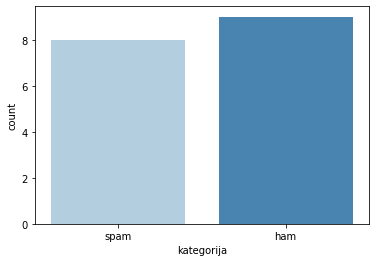

ham     9
spam    8
Name: kategorija, dtype: int64


In [13]:
#Vizualizacija
plt.figure(figsize=(6,4))
sns.countplot(df['kategorija'],palette= 'Blues')
plt.xticks(rotation='horizontal')
plt.show()

print(df.kategorija.value_counts())

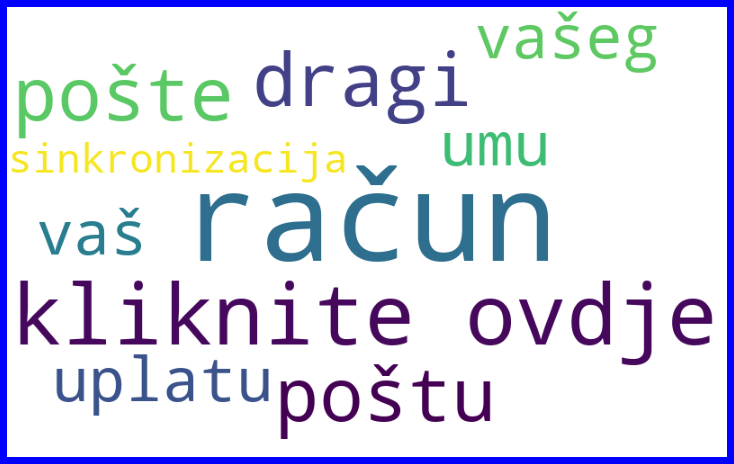

In [14]:
#najčešće riječi u spamu
from wordcloud import WordCloud

spam = df['poruka'][df['kategorija']=='spam']

spam_obl = WordCloud(width=800,height=500,background_color='white',max_words=10).generate(' '.join(spam))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_obl)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [14]:
#Konvertiranje teksta u vektore TF-IDF
#korištenje multinominal klas



tf_vec = TfidfVectorizer()


SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

features = tf_vec.fit_transform(df['poruka'])

X = features
y = df['kategorija']

In [15]:
#predikcija i učenje
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=8)         #test_size=0.20 random_state=8 test_size=0.15


SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)

print ('Rezultat = > ', accuracy_score(y_test,y_pred))

Rezultat = >  0.8


In [16]:
y_pred

array(['spam', 'ham', 'ham', 'ham', 'ham'], dtype=object)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.75      1.00      0.86         3
        spam       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [18]:
#spremanje programa za klasifikaciju
import pickle
filename='email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()